In [1]:
import math
from itertools import compress
import numpy as np
import pandas as pd
from Bio import SeqIO
from scipy.special import binom

# progress bar
from tqdm import tqdm

# custom packages
import tregs

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 12})

from matplotlib import font_manager
font_manager.fontManager.addfont('../../misc/lucida-sans-unicode.ttf')

import seaborn as sns
tregs.mpl_pboc.plotting_style()

{'green': '#7AA974',
 'light_green': '#BFD598',
 'pale_green': '#DCECCB',
 'yellow': '#EAC264',
 'light_yellow': '#F3DAA9',
 'pale_yellow': '#FFEDCE',
 'blue': '#738FC1',
 'light_blue': '#A9BFE3',
 'pale_blue': '#C9D7EE',
 'red': '#D56C55',
 'light_red': '#E8B19D',
 'pale_red': '#F1D4C9',
 'purple': '#AB85AC',
 'light_purple': '#D4C2D9',
 'dark_green': '#7E9D90',
 'dark_brown': '#905426'}

In this notebook, we explore the the level of noise in the information footprint that results from the so-called hitchhiking effect as well as how it scales as a function of library size. 


## Functions

In [2]:
def combine_regions(regions):

    regions = sorted(regions)
    # sorting is necessary: the rest of the function does not work if list is not sorted

    combined_regions = []
    i = 0
    while i < len(regions):
        start = regions[i][0]
        tmp_end = regions[i][1]
        tmp_index = i
        for j in range(i+1, len(regions)):
            if regions[j][0] <= tmp_end:
                tmp_end = regions[j][1]
                tmp_index = j
        combined_regions.append((start, tmp_end))
        i = tmp_index + 1

    return combined_regions


def find_binding_sites(heights, smoothing_winsize, windowsize, stepsize,
                       min_ratio=2):
    cut = int((smoothing_winsize - 1) / 2)
    avg_height = np.mean(heights)

    position = 0
    window_ratio = []
    positions = []
    while position <= (len(heights) - windowsize):
        window = heights[position:(position + windowsize)]
        window_avg = np.mean(window)
        window_ratio.append(window_avg / avg_height)
        positions.append((position - 115 + cut, position + windowsize - 115 + cut))
        position += stepsize

    peak_windows = list(compress(positions, np.asarray(window_ratio) >= min_ratio))
    binding_sites = combine_regions(peak_windows)
    return binding_sites

In [14]:
def signal_to_noise(n_seqs, detect_bsites=True):
    df = tregs.simulate.simrep(lacO1, lacWT, O1, rnap_emat, O1_emat, 
                                ep_wt, er_wt, n_NS, n_p, n_r, num_mutants=n_seqs)
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']

    nbins = 2
    upper_bound = np.mean(mu_data)

    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data,
                                                    lacO1, nbins, upper_bound,
                                                    smoothed=True, windowsize=3)
    exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, lacO1,
                                                    smoothed=True, windowsize=3)
    
    binding_sites = find_binding_sites(footprint, smoothing_winsize=3,
                                       windowsize=2, stepsize=1, min_ratio=2)
    if len(binding_sites) == 0 or not detect_bsites:
        binding_sites = np.asarray([[76, 84], [97, 108], [115, 132]]) - 114

    binding_sites = np.asarray(binding_sites) + 114

    noise_footprint = []
    start = 0
    for binding_site in binding_sites:
        noise_footprint.append(footprint[start:binding_site[0]])
        start = binding_site[1]
        last_binding_site = binding_site
    noise_footprint.append(footprint[start:])
    noise = np.concatenate(tuple(noise_footprint), axis=None)

    signal_footprint = []
    for binding_site in binding_sites:
        signal_footprint.append(footprint[binding_site[0]:binding_site[1]])
    signal = np.concatenate(tuple(signal_footprint), axis=None)
    
    return footprint, exshift_list, noise, signal

## Loading data

In [6]:
## Loading WT promoter sequence

# Promoter
lacWT = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequences
O1 = 'AATTGTGAGCGGATAACAATT'

_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacO1_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
lacO1 = tregs.seq_utils.get_regulatory_region(genome, lacO1_TSS, reverse=True)

In [8]:
## Loading and fixing the RNAP energy matrix
rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, lacWT)

## Loading and fixing the lacI energy matrix
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], O1)
O1_emat = np.mean(O1_1027_fixed, axis=0)

In [9]:
## specifying parameters
n_NS = len(genome)
n_p = 4600
n_r = 10

ep_wt = -5
er_wt = -15

## Plotting average signal and average noise as a function of library size

In [25]:
library_size = np.rint(10 ** np.arange(2, 5.01, 0.02))
noise = []
signal = []

for i in tqdm(range(len(library_size))):
    size = library_size[i]
    noise_tmp = []
    signal_tmp = []
    for j in range(5):
        n, s = signal_to_noise(int(size))
        noise_tmp.append(np.sum(n) / len(n))
        signal_tmp.append(np.sum(s) / len(s))
    noise.append(np.mean(noise_tmp))
    signal.append(np.mean(signal_tmp))

100%|██████████| 151/151 [1:11:42<00:00, 28.50s/it] 


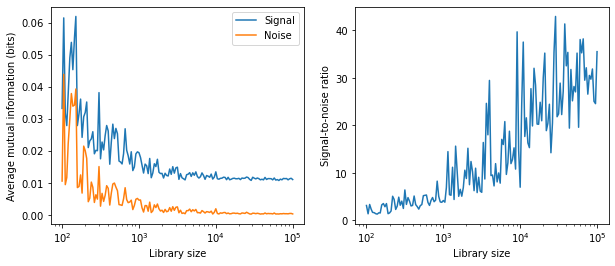

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
ax1, ax2 = axes

ax1.plot(library_size, signal)
ax1.plot(library_size, noise)
ax1.set_xlabel('Library size')
ax1.set_ylabel('Average mutual information (bits)')
ax1.set_xscale('log')
ax1.legend(['Signal', 'Noise'])

ax2.plot(library_size, np.asarray(signal) / np.asarray(noise))
ax2.set_xlabel('Library size')
ax2.set_ylabel('Signal-to-noise ratio')
ax2.set_xscale('log')

plt.savefig('../figs/noise_level_varying_library_size.png', dpi=300)
plt.show()

## Distribution of mutual informatioin in the specific and non-specific binding sites

In [15]:
footprint_small, exshift_small, noise_small, signal_small = signal_to_noise(n_seqs=100, detect_bsites=False)
footprint_medium, exshift_medium, noise_medium, signal_medium = signal_to_noise(n_seqs=500, detect_bsites=False)
footprint_large, exshift_large, noise_large, signal_large = signal_to_noise(n_seqs=1000, detect_bsites=False)

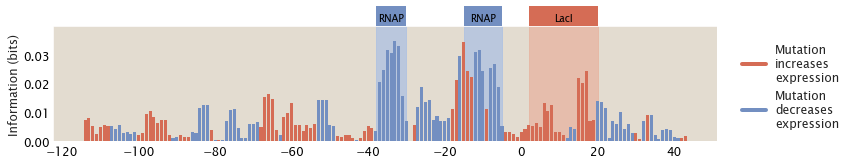

In [19]:
fig, ax = plt.subplots(figsize=(12,2.5))

ax.axvspan(-38, -30, alpha=0.7, color='#A9BFE3')
ax.axvspan(-15, -5, alpha=0.7, color='#A9BFE3')
ax.axvspan(2, 20, alpha=0.7, color='#E8B19D')

footprint = footprint_small
exshift_list = exshift_small
ax.set_ylim(top=max(footprint)*1.15)
ax.add_patch(mpl.patches.Rectangle((-38, max(footprint)*1.15),
                                        8,
                                        max(footprint) * 0.2,
                                        facecolor='#738FC1',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(-38 + 0.5 * 8, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
         ha='center', va='baseline')

ax.add_patch(mpl.patches.Rectangle((-15, max(footprint)*1.15),
                                        10,
                                        max(footprint) * 0.2,
                                        facecolor='#738FC1',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(-15 + 0.5 * 10, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
         ha='center', va='baseline')

ax.add_patch(mpl.patches.Rectangle((2, max(footprint)*1.15),
                                        18,
                                        max(footprint) * 0.2,
                                        facecolor='#D56C55',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(2 + 0.5 * 18, max(footprint) * 1.2, 'LacI', fontsize = 10, color = 'k',
         ha='center', va='baseline')


windowsize=3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
ax.set_ylabel('Information (bits)', fontsize=12)

custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                Line2D([0], [0], color='#738FC1', lw=4)]
plt.legend(custom_lines,
           ['Mutation\nincreases\nexpression', 'Mutation\ndecreases\nexpression'],
           bbox_to_anchor=(1.2, 0.95), frameon=False)

plt.tight_layout()
plt.savefig('../../figs/simrep_footprint_library100.png', dpi=300, bbox_inches='tight')
plt.show()

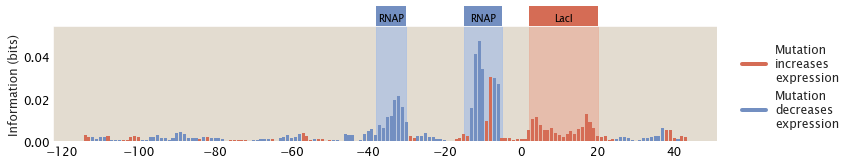

In [20]:
fig, ax = plt.subplots(figsize=(12,2.5))

ax.axvspan(-38, -30, alpha=0.7, color='#A9BFE3')
ax.axvspan(-15, -5, alpha=0.7, color='#A9BFE3')
ax.axvspan(2, 20, alpha=0.7, color='#E8B19D')

footprint = footprint_medium
exshift_list = exshift_medium
ax.set_ylim(top=max(footprint)*1.15)
ax.add_patch(mpl.patches.Rectangle((-38, max(footprint)*1.15),
                                        8,
                                        max(footprint) * 0.2,
                                        facecolor='#738FC1',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(-38 + 0.5 * 8, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
         ha='center', va='baseline')

ax.add_patch(mpl.patches.Rectangle((-15, max(footprint)*1.15),
                                        10,
                                        max(footprint) * 0.2,
                                        facecolor='#738FC1',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(-15 + 0.5 * 10, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
         ha='center', va='baseline')

ax.add_patch(mpl.patches.Rectangle((2, max(footprint)*1.15),
                                        18,
                                        max(footprint) * 0.2,
                                        facecolor='#D56C55',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(2 + 0.5 * 18, max(footprint) * 1.2, 'LacI', fontsize = 10, color = 'k',
         ha='center', va='baseline')


windowsize=3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
ax.set_ylabel('Information (bits)', fontsize=12)

custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                Line2D([0], [0], color='#738FC1', lw=4)]
plt.legend(custom_lines,
           ['Mutation\nincreases\nexpression', 'Mutation\ndecreases\nexpression'],
           bbox_to_anchor=(1.2, 0.95), frameon=False)

plt.tight_layout()
plt.savefig('../../figs/simrep_footprint_library500.png', dpi=300, bbox_inches='tight')
plt.show()

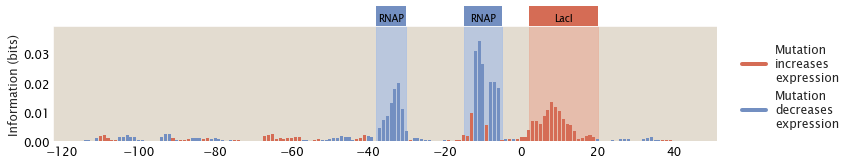

In [21]:
fig, ax = plt.subplots(figsize=(12,2.5))

ax.axvspan(-38, -30, alpha=0.7, color='#A9BFE3')
ax.axvspan(-15, -5, alpha=0.7, color='#A9BFE3')
ax.axvspan(2, 20, alpha=0.7, color='#E8B19D')

footprint = footprint_large
exshift_list = exshift_large
ax.set_ylim(top=max(footprint)*1.15)
ax.add_patch(mpl.patches.Rectangle((-38, max(footprint)*1.15),
                                        8,
                                        max(footprint) * 0.2,
                                        facecolor='#738FC1',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(-38 + 0.5 * 8, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
         ha='center', va='baseline')

ax.add_patch(mpl.patches.Rectangle((-15, max(footprint)*1.15),
                                        10,
                                        max(footprint) * 0.2,
                                        facecolor='#738FC1',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(-15 + 0.5 * 10, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
         ha='center', va='baseline')

ax.add_patch(mpl.patches.Rectangle((2, max(footprint)*1.15),
                                        18,
                                        max(footprint) * 0.2,
                                        facecolor='#D56C55',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(2 + 0.5 * 18, max(footprint) * 1.2, 'LacI', fontsize = 10, color = 'k',
         ha='center', va='baseline')


windowsize=3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
ax.set_ylabel('Information (bits)', fontsize=12)

custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                Line2D([0], [0], color='#738FC1', lw=4)]
plt.legend(custom_lines,
           ['Mutation\nincreases\nexpression', 'Mutation\ndecreases\nexpression'],
           bbox_to_anchor=(1.2, 0.95), frameon=False)

plt.tight_layout()
plt.savefig('../../figs/simrep_footprint_library1000.png', dpi=300, bbox_inches='tight')
plt.show()

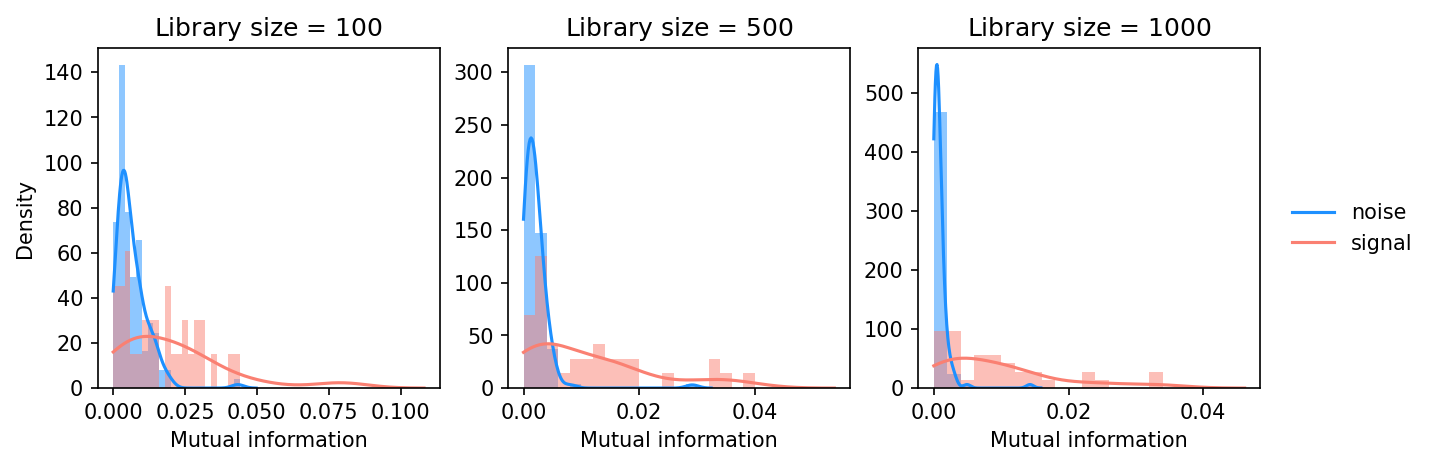

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
ax1, ax2, ax3 = axes

bins=np.arange(0, 0.05, 0.002)
ax1.hist(noise_small, bins=bins, density=True, alpha=0.5, color='dodgerblue')
ax1.hist(signal_small, bins=bins, density=True, alpha=0.5, color='salmon')
sns.kdeplot(noise_small, clip=(0,1), ax=ax1, color='dodgerblue')
sns.kdeplot(signal_small, clip=(0,1), ax=ax1, color='salmon')
ax1.set_title('Library size = $100$')
ax1.set_xlabel('Mutual information')

bins=np.arange(0, 0.05, 0.002)
ax2.hist(noise_medium, bins=bins, density=True, alpha=0.5, color='dodgerblue')
ax2.hist(signal_medium, bins=bins, density=True, alpha=0.5, color='salmon')
sns.kdeplot(noise_medium, clip=(0,1), ax=ax2, color='dodgerblue')
sns.kdeplot(signal_medium, clip=(0,1), ax=ax2, color='salmon')
ax2.set_title('Library size = $500$')
ax2.set_xlabel('Mutual information')
ax2.set_ylabel('')

bins=np.arange(0, 0.04, 0.002)
ax3.hist(noise_large, bins=bins, density=True, alpha=0.5, color='dodgerblue')
ax3.hist(signal_large, bins=bins, density=True, alpha=0.5, color='salmon')
sns.kdeplot(noise_large, clip=(0,1), ax=ax3, color='dodgerblue')
sns.kdeplot(signal_large, clip=(0,1), ax=ax3, color='salmon')
ax3.set_title('Library size = $1000$')
ax3.set_xlabel('Mutual information')
ax3.set_ylabel('')
ax3.legend(['noise', 'signal'], bbox_to_anchor=(1.5, 0.6), frameon=False)

plt.show()

## Writing signal-to-noise ratio as a function of library size

Recall that the expression for the information footprint at each position $i$ is
$$
I_i = \sum_{b} \sum_{\mu} P_{i}(b, \mu) \log_2{(\frac{P_{i}(b, \mu)}{P_i(b)P(\mu)})},
$$
where $b$ represents base identity and $\mu$ represents expression levels. This means that at any given position $i$, if $I_i = 0$, then it must be true that $\forall b, u$, we have
$$
\begin{align}
    &P_i(b,u) = P_i(b)P(\mu) \\
    \mathrm{or}\ &P_i(b, \mu) = 0.
\end{align}
$$
In other words, in the case of a non-zero joint probability, we require the base identity at a certain position to be independent of the expression levels. The question is whether these conditions hold for the non-specific binding sites. If not, then we would observe "residual" mutual information or noise at those sites.

To address this question, let us consider a set of $n$ promoter variants and a non-specific binding site at position $j$. Since we are making random mutations, whether site $j$ is wild type or mutant is independent of the sequence of letters that show up in the specific binding site. Since only the sequence in the specific binding site would affect the expression levels, this means that the base identity at site $j$ should also be independent of which expression bin the promoter variant falls into. However, because of the limited size of the library, this is not necessarily true mathematically. Let's take a look at how this might happen.

Let's suppose that at position $j$, $n_{\mathrm{WT}}$ sequences have the wild type base identity, and $n - n_{\mathrm{WT}}$ sequences have a mutant base identity. (Of course, as $n \rightarrow \infty$, we have that $n_{\mathrm{WT}} = n - n_{\mathrm{WT}} = \frac{1}{2} n$. To keep the analysis more general, here we do not take the limit, and we will see later on that the fraction of wild type bases here does not actually matter.) This means that
$$
P_{b,j} = \begin{cases}
      n_{\mathrm{WT}} / n, & \text{if the base is wild type} \\
      1 - n_{\mathrm{WT}} / n, & \text{otherwise}.
    \end{cases}
$$

Without loss of generality, we consider two expression bins, one for high expression and one for low expression, and let us assume
$$
P_{\mu} = \begin{cases}
      \alpha, & \text{if the promoter variant leads to low expression} \\
      1 - \alpha, & \text{if the promoter variant leads to high expression}.
    \end{cases}
$$

Since the base identity at position $j$ does not affect $P_{\mu}$, within the set of $n_{\mathrm{WT}}$ sequences with wild type base identity at position $j$ and within the set of $n - n_{\mathrm{WT}}$ sequences with mutant base identity at position $j$, the proportion of sequences in the high expression bin versus the low expression bin can be approximated by the outcome of a Bernoulli trial with the success rate $p = \alpha$. Suppose the proportion of wild type sequences with low expression is $\beta$, it is not guaranteed that $\beta = \alpha$.

In [2]:
def get_MI(n_WT_high, n_WT_low, n_mut_high, n_mut_low):

    n_WT = n_WT_low + n_WT_high
    n_mut = n_mut_low + n_mut_high
    n_tot = n_WT + n_mut
    
    p_b = np.asarray([n_WT, n_mut]) / n_tot
    p_mu = np.asarray([n_WT_high + n_mut_high, n_WT_low + n_mut_low]) / n_tot
    p_joint = np.asarray([[n_WT_high, n_WT_low],
                          [n_mut_high, n_mut_low]]) / n_tot
    MI = p_joint[0, 0] * np.log2(p_joint[0, 0] / (p_b[0] * p_mu[0]))
    MI += p_joint[0, 1] * np.log2(p_joint[0, 1] / (p_b[0] * p_mu[1]))
    MI += p_joint[1, 0] * np.log2(p_joint[1, 0] / (p_b[1] * p_mu[0]))
    MI += p_joint[1, 1] * np.log2(p_joint[1, 1] / (p_b[1] * p_mu[1]))

    if MI < 0 and MI >= -10**(-6):
        MI = 0

    return MI

In [27]:
def bernoulli(alpha, n_WT_high, n_WT_low, n_mut_high, n_mut_low):
    n_WT = n_WT_low + n_WT_high
    n_mut = n_mut_low + n_mut_high
    p1 = binom(n_WT, n_WT_high) * alpha**n_WT_high * (1 - alpha)**n_WT_low
    p2 = binom(n_mut, n_mut_high) * alpha**n_mut_high * (1 - alpha)**n_mut_low
    return p1 * p2

In [5]:
def simulate_bernoulli(alpha, n):
    df_list = []
    n_WT = int(0.9 * n) # should be 90%
    n_mut = int(0.1 * n)
    for n_WT_low in range(1, n_WT):
        n_WT_high = n_WT - n_WT_low
        for n_mut_low in range(1, n_mut):
            n_mut_high = n_mut - n_mut_low
            MI = get_MI(n_WT_high, n_WT_low, n_mut_high, n_mut_low)
            p = bernoulli(alpha, n_WT_high, n_WT_low, n_mut_high, n_mut_low)
            rv = {}
            rv['n_WT_low'] = n_WT_low
            rv['n_WT_high'] = n_WT_high
            rv['n_mut_low'] = n_mut_low
            rv['n_mut_high'] = n_mut_high
            rv['MI'] = MI
            rv['p'] = p
            df_list.append(rv)
    df = pd.DataFrame(df_list)

    #df = df.groupby(['MI'], as_index=False)['p'].agg('sum')
    p_sum = np.sum(df['p'])
    df['norm_p'] = df['p'] / p_sum
    df = df.sort_values(by='MI', ascending=True)
    return df

In [6]:
df1 = simulate_bernoulli(alpha=0.5, n=50)
df2 = simulate_bernoulli(alpha=0.5, n=100)
df3 = simulate_bernoulli(alpha=0.5, n=1000)

In [8]:
df3.head(50)

,n_WT_low,n_WT_high,n_mut_low,n_mut_high,MI,p,norm_p
44500,450,450,50,50,0.0,2.116180e-03,2.116180e-03
5252,54,846,6,94,0.0,3.216951e-205,3.216951e-205
75720,765,135,85,15,0.0,1.467797e-120,1.467797e-120
42716,432,468,48,52,0.0,9.521756e-04,9.521756e-04
23984,243,657,27,73,0.0,5.063775e-51,5.063775e-51
8820,90,810,10,90,0.0,8.282043e-163,8.282043e-163
60556,612,288,68,32,0.0,3.995258e-32,3.995258e-32
36472,369,531,41,59,0.0,1.843907e-10,1.843907e-10
83748,846,54,94,6,0.0,3.216951e-205,3.216951e-205
24876,252,648,28,72,0.0,8.034780e-47,8.034780e-47


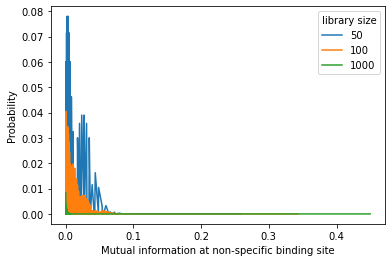

In [29]:
fig, ax = plt.subplots()
ax.plot(df1['MI'], df1['norm_p'])
ax.plot(df2['MI'], df2['norm_p'])
ax.plot(df3['MI'], df3['norm_p'])
ax.legend([1, 2, 3])

ax.set_xlabel('Mutual information at non-specific binding site')
ax.set_ylabel('Probability')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.legend([x for x in [50, 100, 1000]], title='library size')
plt.show()

To find the probability distribution for the specific binding site:
- consider energy matrix where mutation at each site to each base identity lead to the same change in binding affinity
- therefore expression levels is a function of the number of mutations
- calculate probability of transition to each bin when new mutation is made

In [10]:
np.sum(df3.p * df3.MI)

0.0007250438523376461

In [11]:
np.sum(df2.p * df2.MI)

0.007471772135540407

In [ ]:
def simulate_bernoulli(alpha, n):
    df_list = []
    n_WT = int(0.9 * n) # should be 90%
    n_mut = int(0.1 * n)
    for n_WT_low in range(1, n_WT):
        n_WT_high = n_WT - n_WT_low
        for n_mut_low in range(1, n_mut):
            n_mut_high = n_mut - n_mut_low
            MI = get_MI(n_WT_high, n_WT_low, n_mut_high, n_mut_low)
            p = bernoulli(alpha, n_WT_high, n_WT_low, n_mut_high, n_mut_low)
            rv = {}
            rv['n_WT_low'] = n_WT_low
            rv['n_WT_high'] = n_WT_high
            rv['n_mut_low'] = n_mut_low
            rv['n_mut_high'] = n_mut_high
            rv['MI'] = MI
            rv['p'] = p
            df_list.append(rv)
    df = pd.DataFrame(df_list)

    #df = df.groupby(['MI'], as_index=False)['p'].agg('sum')
    p_sum = np.sum(df['p'])
    df['norm_p'] = df['p'] / p_sum
    df = df.sort_values(by='MI', ascending=True)
    return df

In [31]:
x = np.zeros(20)
for (i, n) in enumerate(np.logspace(2, 4, 20)):    
    df = simulate_bernoulli(alpha=0.5, n=n)
    x[i] = np.sum(df.p * df.MI)

/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_22976/334837168.py:4: RuntimeWarning: invalid value encountered in double_scalars
  p1 = binom(n_WT, n_WT_high) * alpha**n_WT_high * (1 - alpha)**n_WT_low
/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_22976/334837168.py:4: RuntimeWarning: invalid value encountered in double_scalars
  p1 = binom(n_WT, n_WT_high) * alpha**n_WT_high * (1 - alpha)**n_WT_low
/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_22976/334837168.py:4: RuntimeWarning: invalid value encountered in double_scalars
  p1 = binom(n_WT, n_WT_high) * alpha**n_WT_high * (1 - alpha)**n_WT_low
/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_22976/334837168.py:4: RuntimeWarning: invalid value encountered in double_scalars
  p1 = binom(n_WT, n_WT_high) * alpha**n_WT_high * (1 - alpha)**n_WT_low
/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_22976/334837168.py:4: RuntimeWarning: invalid value encountered in double_scalars
  p

In [ ]:
plt.plot(np.logspace(2, 4, 20), x)